In [61]:
%reset -f
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate

from joblib import Parallel, delayed


In [62]:
# Load the variables from tov-final
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
P_c   = 1.0e-1          # central pressure (maximal pressure)

# Specify and load the file
filename    = f'data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy'
loaded_data = np.load(filename)

# Unpack the values
r, m, P, rho, R, alpha, psi = loaded_data

# Define polytropic constants (using c = G = 1 units for simplicity)
K     = 100    # Polytropic constant
Gamma = 2      # Polytropic exponent

# Polytropic Equation of State (EOS)
def pressure(rho):
    return K * rho**Gamma

In [63]:
# Variables to be plotted
W  = 1
v  = np.zeros_like(rho)

E  = rho
Sr = rho * (1 + P/rho) * W**2 * v
S  = rho * (1 + P/rho) * W**2 * v**2 + 3 * P

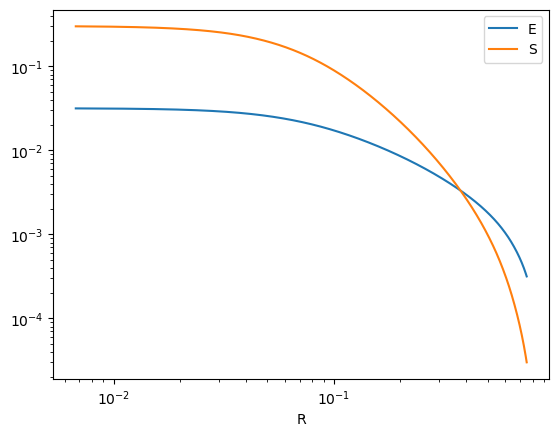

In [64]:
# Visualization
plt.figure
plt.plot(R, E, label="E")
plt.plot(R, S, label="S")
# plt.plot(R, Sr, label=r"$S^r$")
plt.xscale('log')
plt.yscale('log')

plt.xlabel("R")
plt.legend()
plt.show()


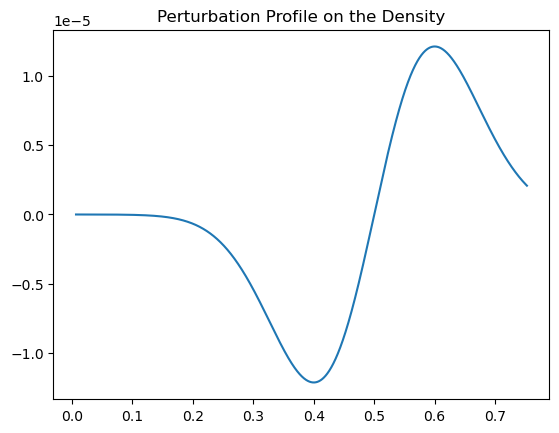

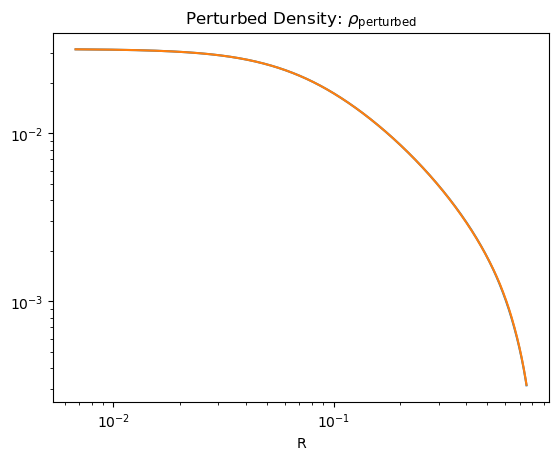

In [65]:
# Now apply a perturbation on the density rho
# Perturbation parameters
center_value = 0.5        # Center value
sigma        = 1.0e-1     # Width of the full Gaussian
amplitude    = 1.0e-4     # Scale factor

# Center Gaussian
center_index = np.argmin(np.abs(R - center_value))
R_centered = (R - R[center_index])/R[center_index]
gaussian = amplitude * np.exp(-((R - R[center_index]) ** 2) / (2 * sigma**2))

# Multiplication of Gaussian
perturbation = gaussian * R_centered
rho_perturbed = rho + gaussian * R_centered


# Visualization
plt.figure(1)
plt.plot(R, perturbation)
plt.title("Perturbation Profile on the Density")

plt.figure(2)
plt.plot(R, rho);
plt.plot(R, rho_perturbed);
plt.xlabel('R');
plt.xscale('log');
plt.yscale('log');
plt.title(r"Perturbed Density: $\rho_{\text{perturbed}}$");


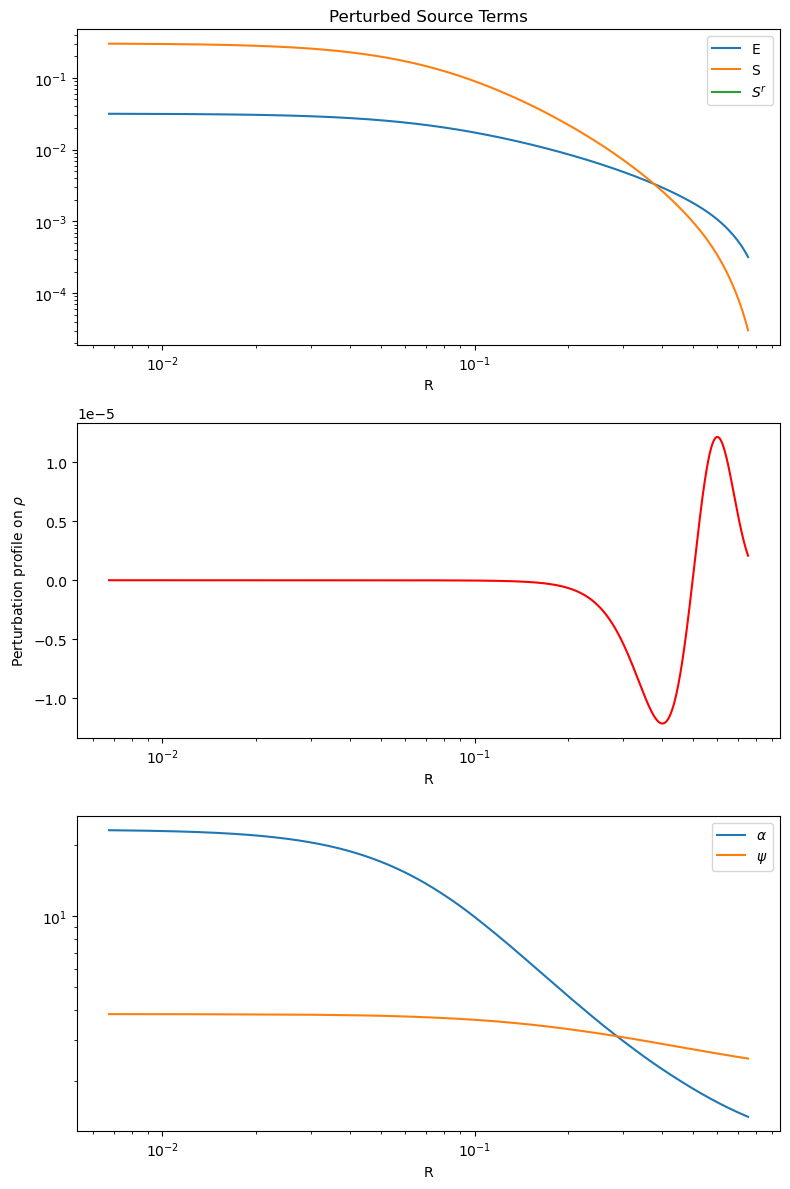

In [66]:
# Density perturbation of the source terms
E_perturbed  = rho_perturbed
Sr_perturbed = rho_perturbed * (1 + P/rho) * W**2 * v
S_perturbed  = rho * (1 + pressure(rho_perturbed)/rho) * W**2 * v**2 + 3 * pressure(rho_perturbed)

plt.figure(figsize=(8, 12))

# Figure: Perturbed source terms
plt.subplot(3, 1, 1)
plt.plot(R, E_perturbed,  label= "E")
plt.plot(R, S_perturbed,  label= "S")
plt.plot(R, Sr_perturbed, label= r"$S^r$")

# x- and y-scale
plt.yscale('log')
plt.xscale('log')
plt.xlabel('R')

# Title
plt.legend()
plt.title("Perturbed Source Terms")

# Figure: Perturbed velocity
plt.subplot(3, 1, 2)
plt.plot(R, perturbation, color="red")
plt.xscale('log')  
plt.xlabel('R')
plt.ylabel(r"Perturbation profile on $\rho$")


# Figure: Alpha and Psi
plt.subplot(3, 1, 3)
plt.plot(R, alpha,  label= r"$\alpha$")
plt.plot(R, psi,  label= r"$\psi$")
plt.xscale('log')  
plt.yscale('log')
plt.xlabel('R')
plt.legend()

plt.tight_layout()
plt.show()


Given the perturbation on the density, the vector equations are trivially zero.

We focus on the the first scalar equation to solve is:

\begin{equation}
\left(\nabla^{2} + S_{1} \psi^{2} + 7 S_{7} \psi^{8} \right) \delta \psi = \delta S_{1} \psi + \delta S_{7} \psi^{7}
\end{equation}

Such that:
\begin{equation}
    k^{2}_{\psi} = -S_{1} \psi^{2} - 7 S_{7} \psi^{8} 
\end{equation}
in which $S_{1} = -2 \pi \rho_{perturbed}$ and $S_7 = 0$.

The right-hand sides are given by:
\begin{equation}
    \delta S_1 = -2 \pi \delta E = - 2 \pi \delta \rho
\end{equation}

\begin{equation}
    \delta S_7 = 0
\end{equation}

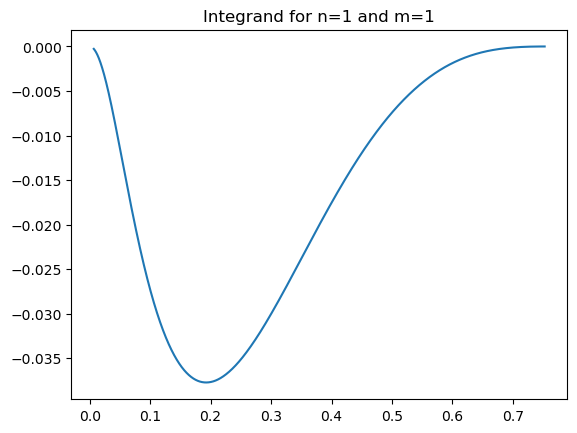

In [67]:
# Define the upper integration bound
R_max = np.max(R)

# Definition of S1
S1 = -2 * np.pi * rho_perturbed

# Definition of source term
source_term_1 = -2*np.pi*perturbation*psi

# Relevant functions
k = - S1 * psi**(2)
l = lambda n, x: np.sqrt(2) * np.sin(n * np.pi * x / R_max)
λ = lambda n   : - (n * np.pi / R_max)**2

k_interp = interpolate.interp1d(R, k, kind='cubic', fill_value='extrapolate')
# Integration
def integrand(x, n, m):
    # denumerator: negative due to the product of two complex values
    return l(n, x) * k_interp(x) * np.conj(l(m, x)) / (- np.sqrt(-λ(n)) * np.sqrt(-λ(m)))              

# Visulation of the integrand
n, m = 1, 1
plt.figure(1)
plt.plot(R, integrand(R, n, m));
plt.title(f"Integrand for n={n} and m={m}");

In [68]:
# Computation of K tilde
n_max, m_max = 100, 100

def compute_integral(n, m):
    return integrate.quad(integrand, 0, R_max, args=(n + 1, m + 1))[0]

start = time.time()

K_tilde =  (- np.sqrt(-λ(n)) * np.sqrt(-λ(m))) * np.array(Parallel(n_jobs=-1)(delayed(compute_integral)(n, m) for n in range(n_max) for m in range(m_max))).reshape(n_max, m_max)

stop = time.time()

print(f"Elapsed time: {stop - start}")

Elapsed time: 106.2266936302185


In [69]:
# Computation of lambda dirac
lambda_dirac = np.diag([(- np.sqrt(-λ(n)) * np.sqrt(-λ(n))) for n in range(n_max)])


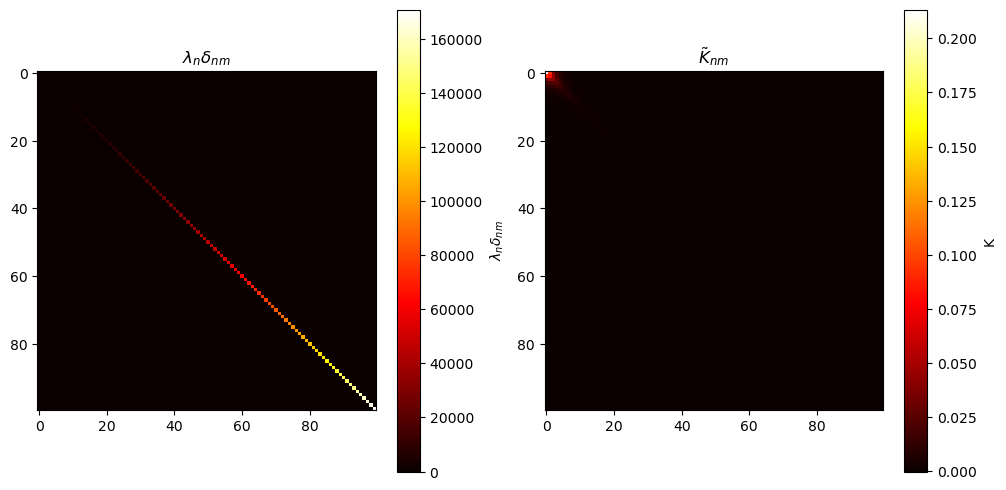

In [70]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First subplot: abs(lambda_dirac)
im1 = axes[0].imshow(np.abs(lambda_dirac), cmap="hot")
axes[0].set_title(r"$\lambda_n \delta_{nm}$")
fig.colorbar(im1, ax=axes[0], label=r"$\lambda_n \delta_{nm}$")

# Second subplot: abs(K)
im2 = axes[1].imshow(K_tilde, cmap="hot")
axes[1].set_title(r"$\tilde{K}_{nm}$")
fig.colorbar(im2, ax=axes[1], label="K")

In [71]:
# Reformulate the problem as Cx = d
C = lambda_dirac + K_tilde


In [72]:
# Interpolation of Sr_perturbed
source_term_1_int = interpolate.interp1d(R, R*source_term_1, kind='cubic', fill_value="extrapolate")

def integrand_b(x, n):
    return l(n, x) * source_term_1_int(x)

d = np.zeros(C.shape[0]).squeeze()
for n in range(n_max):
    d[n] = integrate.quad(integrand_b, 0, R[-1], args=n+1)[0]
    

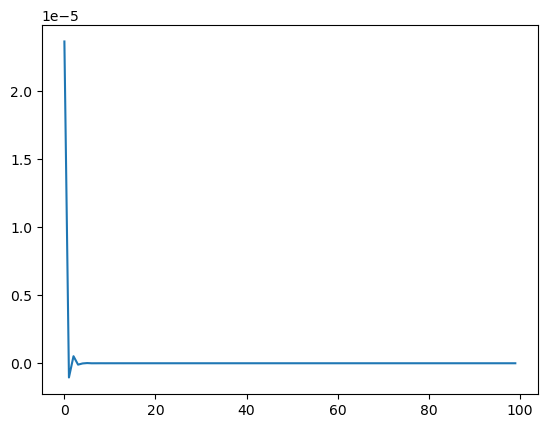

In [73]:
f = np.linalg.solve(C, d)
plt.plot(f);

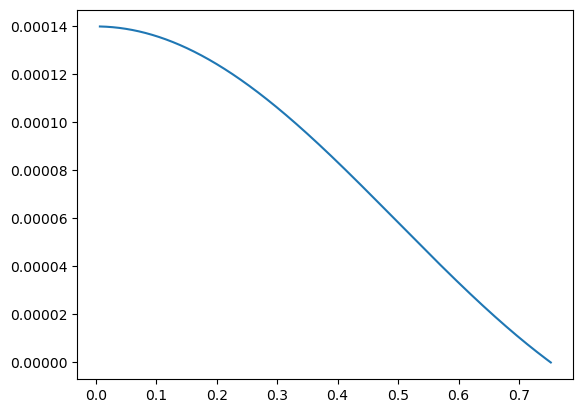

In [74]:
dpsi_solution = lambda x: [f[n]*l(n+1, x) for n in range(len(f))][0]

plt.figure()
plt.plot(R, dpsi_solution(R)/R);

The second scalar equation to solve is:
\begin{equation}
    \left(\nabla^{2} - S_{\alpha\psi} \right) \delta \left( \alpha \psi \right) = \left( \alpha \psi \right) \delta S_{\alpha\psi}
\end{equation}
Such that:
\begin{equation}
    k^{2}_{\alpha \psi} = S_{\alpha \psi}
\end{equation}
in which $S_{\alpha \psi} = 2 \pi (E + 2S) / \psi^2 = 2 \pi (\rho + 6p) / \psi^2$
The right-hand sides are given by:
\begin{equation}
    \delta S_{\alpha \psi} = 2 \pi ((\delta E + 2 \delta S) \psi - 2 (E + 2S) \delta \psi) / \psi^3 
\end{equation}

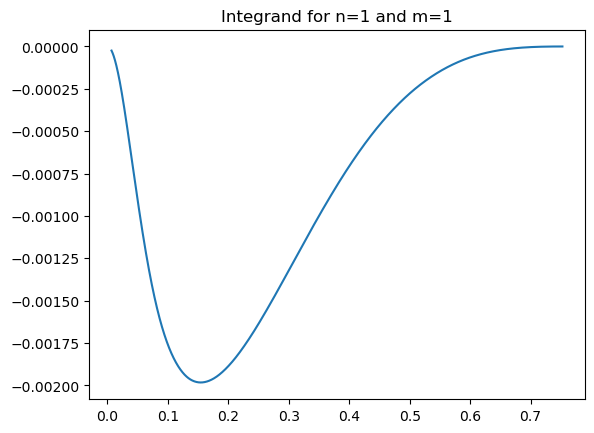

In [75]:
# Define the upper integration bound
R_max = np.max(R)

S_alpha_psi = 2 * np.pi * (rho_perturbed + 6 * pressure(rho_perturbed)) / psi**2

# Definition of source term
source_term_2 = alpha*psi*2*np.pi*((perturbation + 2 * 3 * pressure(perturbation))*psi - 2*(rho + 2 * 3 * pressure(rho) * dpsi_solution(R))/psi**3)

# Relevant functions
k = 2 * np.pi * (rho_perturbed + 6 * pressure(rho_perturbed)) / psi**2
l = lambda n, x: np.sqrt(2) * np.sin(n * np.pi * x / R_max)
λ = lambda n   : - (n * np.pi / R_max)**2

k_interp = interpolate.interp1d(R, k, kind='cubic', fill_value='extrapolate')
# Integration
def integrand(x, n, m):
    # denumerator: negative due to the product of two complex values
    return l(n, x) * k_interp(x) * np.conj(l(m, x)) / (- np.sqrt(-λ(n)) * np.sqrt(-λ(m)))              

# Visulation of the integrand
n, m = 1, 1
plt.figure(1)
plt.plot(R, integrand(R, n, m));
plt.title(f"Integrand for n={n} and m={m}");


In [76]:
# Computation of K tilde
n_max, m_max = 100, 100

def compute_integral(n, m):
    return integrate.quad(integrand, 0, R_max, args=(n + 1, m + 1))[0]

start = time.time()

K_tilde =  (- np.sqrt(-λ(n)) * np.sqrt(-λ(m))) * np.array(Parallel(n_jobs=-1)(delayed(compute_integral)(n, m) for n in range(n_max) for m in range(m_max))).reshape(n_max, m_max)

stop = time.time()

print(f"Elapsed time: {stop - start}")


Elapsed time: 59.44965958595276


In [77]:
# Computation of lambda dirac
lambda_dirac = np.diag([(- np.sqrt(-λ(n)) * np.sqrt(-λ(n))) for n in range(n_max)])


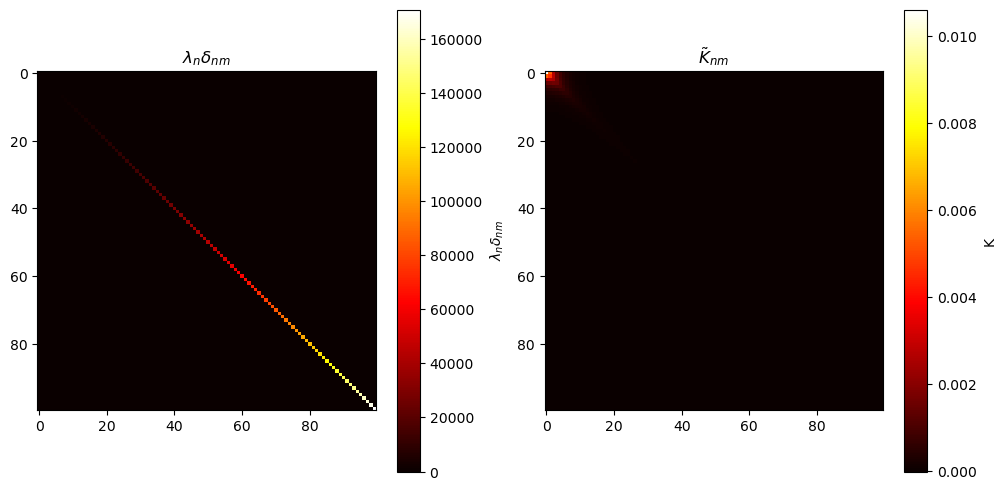

In [78]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First subplot: abs(lambda_dirac)
im1 = axes[0].imshow(np.abs(lambda_dirac), cmap="hot")
axes[0].set_title(r"$\lambda_n \delta_{nm}$")
fig.colorbar(im1, ax=axes[0], label=r"$\lambda_n \delta_{nm}$")

# Second subplot: abs(K)
im2 = axes[1].imshow(K_tilde, cmap="hot")
axes[1].set_title(r"$\tilde{K}_{nm}$")
fig.colorbar(im2, ax=axes[1], label="K")

In [79]:
# Reformulate the problem as Cx = d
C = lambda_dirac + K_tilde


In [80]:
# Interpolation of Sr_perturbed
source_term_2_int = interpolate.interp1d(R, R*source_term_2, kind='cubic', fill_value="extrapolate")

def integrand_b(x, n):
    return l(n, x) * source_term_2_int(x)

d = np.zeros(C.shape[0]).squeeze()
for n in range(n_max):
    d[n] = integrate.quad(integrand_b, 0, R[-1], args=n+1)[0]
    

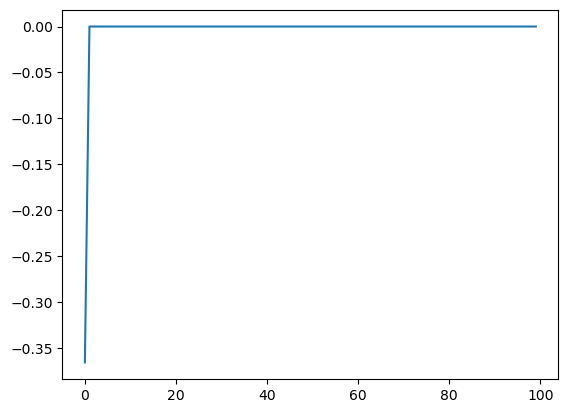

In [81]:
g = np.linalg.solve(C, d)
plt.plot(g)

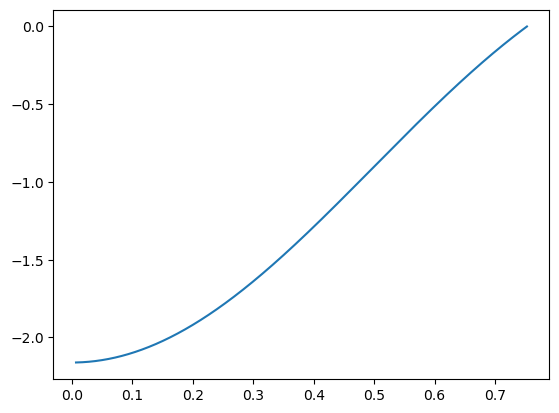

In [82]:
d_alpha_psi_solution = lambda x: [g[n]*l(n+1, x) for n in range(len(g))][0]

plt.figure()
plt.plot(R, d_alpha_psi_solution(R)/R)

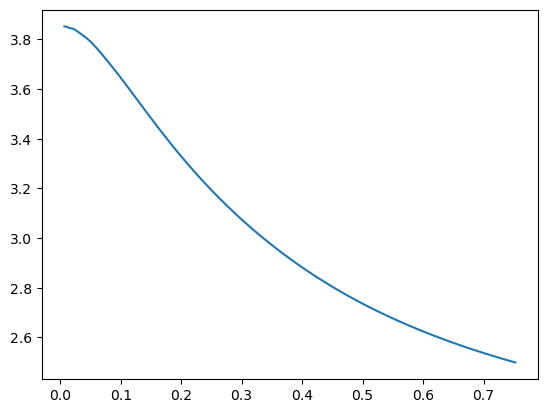

In [83]:
plt.figure()
plt.plot(R, psi + dpsi_solution(R))

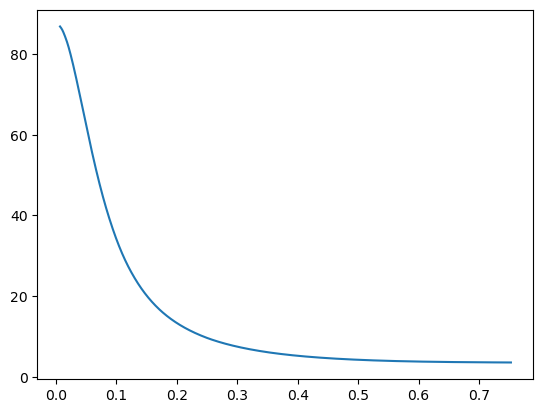

In [84]:
plt.plot()
# plt.plot(R, alpha*psi)
plt.plot(R, alpha*psi + d_alpha_psi_solution(R)/R)